In [10]:
import numpy as np
import random
import os

from glob import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchviz import make_dot
import torchvision.models as models
from torchvision import transforms

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")

Selected device: cuda


In [11]:
CFG = {
    'IMG_SIZE': 320,
    'EPOCHS': 10,
    'LEARNING_RATE': 0.01,
    'BATCH_SIZE': 64,
    'SEED': 41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [12]:
training_data_folder = rf"../dataset/prep_data/lettuce/images/training"
test_data_folder = rf"../dataset/prep_data/lettuce/images/validation"

X_train = []
y_train = []

for filename in os.listdir(training_data_folder):
    if filename.endswith(".png"):
        name, totalDays, vegetableAge = filename.split("_")
        totalDays = int(totalDays)
        vegetableAge = int(vegetableAge.split(".")[0])

        if vegetableAge <= totalDays // 4:
            label = 1
        elif vegetableAge <= 2 * totalDays // 4:
            label = 2
        elif vegetableAge <= 3 * totalDays // 4:
            label = 3
        else:
            label = 4

        image_path = os.path.join(training_data_folder, filename)
        X_train.append(image_path)
        y_train.append(label)

X_test = []
y_test = []

for filename in os.listdir(test_data_folder):
    if filename.endswith(".png"):
        name, totalDays, vegetableAge = filename.split("_")
        totalDays = int(totalDays)
        vegetableAge = int(vegetableAge.split(".")[0])

        if vegetableAge <= totalDays // 4:
            label = 1
        elif vegetableAge <= 2 * totalDays // 4:
            label = 2
        elif vegetableAge <= 3 * totalDays // 4:
            label = 3
        else:
            label = 4

        image_path = os.path.join(test_data_folder, filename)
        X_test.append(image_path)
        y_test.append(label)

print("\nX_train Length:", len(X_train))
print("y_train Length:", len(y_train))
print("\nX_test Length:", len(X_test))
print("y_test Length:", len(y_test))


X_train Length: 425
y_train Length: 425

X_test Length: 7
y_test Length: 7


In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image)

        label = self.label_list[index]
        return image, label
    
    def __len__(self):
        return len(self.img_path_list)

In [14]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [15]:
train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

test_dataset = CustomDataset(X_test, y_test, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [16]:
class train_model(nn.Module):
    def __init__(self, num_channels=128, final_output_size=(1, 1), num_classes=1):
        super(train_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, num_channels, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(final_output_size),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_channels * final_output_size[0] * final_output_size[1], num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 모델 생성
model = train_model(num_channels=128, final_output_size=(1, 1), num_classes=1)

# 모델 출력 확인
print(model)

train_model(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [17]:
import torch
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model().to(device)
summary(model, (3, 320, 320), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 320, 320]             608
              ReLU-2          [-1, 8, 320, 320]               0
         MaxPool2d-3          [-1, 8, 160, 160]               0
            Conv2d-4         [-1, 16, 160, 160]           3,216
              ReLU-5         [-1, 16, 160, 160]               0
         MaxPool2d-6           [-1, 16, 80, 80]               0
            Conv2d-7           [-1, 32, 80, 80]          12,832
              ReLU-8           [-1, 32, 80, 80]               0
         MaxPool2d-9           [-1, 32, 40, 40]               0
           Conv2d-10          [-1, 128, 40, 40]         102,528
             ReLU-11          [-1, 128, 40, 40]               0
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
           Linear-14                   

In [18]:
# # original

# class train_model(nn.Module):
#     def __init__(self, num_classes=1):
#         super(train_model, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Sequential(
#             nn.Linear(256 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

In [19]:
# # original

# import torch
# from torchsummary import summary

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = train_model().to(device)
# summary(model, (3, 320, 320), device=device.type)

In [20]:
# class train_model(nn.Module):
#     def __init__(self):
#         super(train_model, self).__init__()
#         # Layer 1: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(8),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 2: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 3: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 4: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 5: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 6: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         # Layer 7: Convolutional, BatchNorm, ReLU, MaxPooling
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
        
#         # Regressor Layer
#         self.regressor = nn.Linear(512 * 2 * 2, 1)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         x = self.layer7(x)
#         x = torch.flatten(x, start_dim=1)
#         out = self.regressor(x)
#         return out

In [21]:
# import torch
# from torchsummary import summary

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = train_model().to(device)
# summary(model, (3, 320, 320), device=device.type)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model().to(device)

input_data = torch.randn((1, 3, 320, 320)).to(device)

output = model(input_data)
graph = make_dot(output, params=dict(model.named_parameters()))

graph.render("simple_model_graph", format="png", cleanup=True)

'simple_model_graph.png'

In [23]:
# def validation(model, train_loader, criterion, device):
#     model.eval()
#     vali_loss = []
#     vali_label_list = []
#     vali_pred_list = []

#     with torch.no_grad():
#         for img, label in tqdm(iter(train_loader)):
#             img, label = img.float().to(device), label.float().to(device)

#             logit = model(img)
#             loss = criterion(logit.squeeze(1), label)
            
#             vali_loss.append(loss.item())

#             vali_label_list.extend(label.cpu().numpy())
#             vali_pred_list.extend(logit.squeeze(1).cpu().numpy())

#     vali_mae_loss = np.mean(vali_loss)
#     return vali_mae_loss

In [24]:
def validation(model, dataloader, device):
    threshold=0.5
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predictions = (outputs > threshold).float()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)

    return accuracy

In [25]:
# def train(model, optimizer, train_loader, scheduler, device):
#     model.to(device)

#     criterion = nn.L1Loss().to(device)
#     best_mae = 9999
    
#     for epoch in range(1, CFG["EPOCHS"] + 1):
#         model.train()
#         train_loss = []
#         for img, label in tqdm(iter(train_loader)):
#             img, label = img.float().to(device), label.float().to(device)
            
#             optimizer.zero_grad()
#             logit = model(img)
#             loss = criterion(logit.squeeze(1), label)
#             loss.backward()
#             optimizer.step()

#             train_loss.append(loss.item())

#         if scheduler is not None:
#             scheduler.step()

#         vali_mae = validation(model, train_loader, criterion, device)
#         print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')

#         if best_mae > vali_mae:
#             best_mae = vali_mae
#             os.makedirs('./saved', exist_ok=True)
#             torch.save(model.state_dict(), './saved/best_model.pth')
#             print('Model Saved.')

In [26]:
def train(model, optimizer, train_loader, scheduler, device):
    model.to(device)

    criterion = nn.L1Loss().to(device)
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    
    for epoch in range(1, CFG["EPOCHS"] + 1):
        model.train()
        train_loss = []
        y_true = []
        y_pred = []

        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()
            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            predictions = (logit > 0.5).float()
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

        if scheduler is not None:
            scheduler.step()

        accuracy = accuracy_score(y_true, y_pred)
        print(f'Epoch [{epoch}] Train Loss: [{np.mean(train_loss):.5f}] Train Accuracy: [{accuracy:.5f}]\n')

        train_losses.append(np.mean(train_loss))
        train_accuracies.append(accuracy)

        if best_accuracy < accuracy:
            best_accuracy = accuracy
            os.makedirs('./saved', exist_ok=True)
            torch.save(model.state_dict(), './saved/best_model.pth')
            print('Model Saved.')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.title('Train Loss and Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

In [27]:
# def evaluate(model, test_loader, device):
#     model.eval()
#     vali_label_list = []
#     vali_pred_list = []

#     with torch.no_grad():
#         for img, label in tqdm(iter(test_loader)):
#             img, label = img.float().to(device), label.float().to(device)
#             logit = model(img)
#             vali_label_list.extend(label.cpu().numpy())
#             vali_pred_list.extend(logit.squeeze(1).detach().cpu().numpy())

#     vali_mae = mean_absolute_error(vali_label_list, vali_pred_list)
#     print(f"Test MAE: {vali_mae:.5f}")

In [28]:
def evaluate(model, test_loader, device):
    threshold = 0.5
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predictions = (outputs > threshold).float()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)

    return accuracy

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1] Train Loss: [2.53970] Train Accuracy: [0.00000]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [2] Train Loss: [2.39687] Train Accuracy: [0.00000]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [3] Train Loss: [1.58877] Train Accuracy: [0.16471]

Model Saved.


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [4] Train Loss: [1.25517] Train Accuracy: [0.24706]

Model Saved.


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [5] Train Loss: [1.28250] Train Accuracy: [0.24706]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [6] Train Loss: [1.18358] Train Accuracy: [0.24706]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [7] Train Loss: [1.22368] Train Accuracy: [0.24706]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [8] Train Loss: [1.07356] Train Accuracy: [0.24706]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [9] Train Loss: [1.18199] Train Accuracy: [0.24706]



  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [10] Train Loss: [0.87367] Train Accuracy: [0.24706]



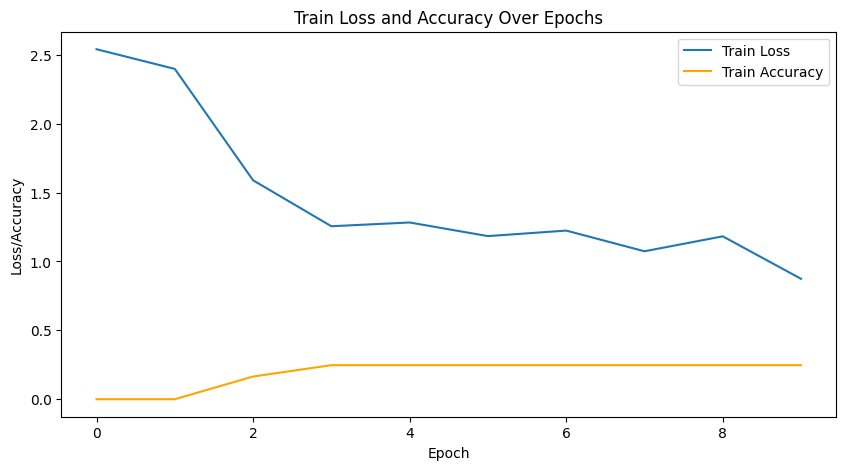

In [29]:
model = train_model().to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

train(model, optimizer, train_loader, scheduler, device)

In [30]:
checkpoint = torch.load('./saved/best_model.pth')
model = train_model().to(device)
model.load_state_dict(checkpoint)

accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.14286


c:\Users\dhksw\Documents\work\PyTorch_practice1\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
